# FastOptSolver - Comparative Evaluation of ISTA and FISTA Algorithms on Housing Data

## Objective

The goal of this project is to implement and compare first-order optimization algorithms for sparse linear regression tasks. 
We focus on ISTA (Iterative Shrinkage-Thresholding Algorithm) and FISTA (Fast Iterative Shrinkage-Thresholding Algorithm), 
two proximal gradient methods commonly used for L1 and mixed regularization problems.

Our experiments will assess the performance of these algorithms using the Boston Housing dataset, 
exploring different regularization strategies (Lasso, Ridge, Elastic Net) and hyperparameter configurations.

This notebook serves as a comprehensive and self-contained experimental framework, 
providing all the necessary code, documentation, and results analysis for the project.

## Data Preparation

We begin by loading and preprocessing the Housing dataset. 
All categorical variables are automatically converted to numeric using binary or one-hot encoding, 
and numerical features can be normalized.

The target variable is selected automatically (defaults to "MEDV" or the last numeric column).

In [1]:
# -----------------------------------------------------------
# Load training data
# -----------------------------------------------------------

from data_loader import load_housing
import pandas as pd

# Load with normalization
X_train, X_test, y_train, y_test = load_housing(normalize=True)

print(f"Training samples: {X_train.shape[0]}, features: {X_train.shape[1]}")

# -----------------------------------------------------------
# Additional dataset information
# -----------------------------------------------------------

import pandas as pd

# Reload full dataframe for inspection
df_full = pd.read_csv("./dataset/Housing.csv")

feature_names = df_full.drop(columns=["MEDV"]).columns.tolist() if "MEDV" in df_full.columns else df_full.columns[:-1].tolist()
target_name = "MEDV" if "MEDV" in df_full.columns else df_full.columns[-1]

print("\nFeature names:")
print(feature_names)

print(f"\nTarget variable: {target_name}")
print(f"Target mean: {y_train.mean():.2f}, Target std: {y_train.std():.2f}")

Training samples: 436, features: 13

Feature names:
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']

Target variable: furnishingstatus
Target mean: 0.69, Target std: 0.85


## Theory Background

### ISTA (Iterative Shrinkage-Thresholding Algorithm)

ISTA is a first-order optimization algorithm designed for solving problems with non-smooth regularization terms, 
such as L1-regularized regression (Lasso). It performs iterative updates combining gradient descent and soft-thresholding:

$$
w^{(k+1)} = \text{soft\_threshold} \left( w^{(k)} - \eta \nabla L(w^{(k)}), \eta \cdot \alpha \right)
$$

where:
- $\eta$ is the step size (learning rate),
- $\alpha$ controls the strength of the L1 penalty.

ISTA has a convergence rate of $O(1/k)$, where $k$ is the iteration number.

---

### FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)

FISTA is an accelerated version of ISTA, introducing a momentum term that speeds up convergence:

$$
t^{(k+1)} = \frac{1 + \sqrt{1 + 4(t^{(k)})^2}}{2}
$$

The weights update incorporates the extrapolation point $y$ to improve convergence, achieving a rate of $O(1/k^2)$.

---

### Regularization Functions

- **Lasso Loss** adds an L1 penalty to encourage sparsity.
- **Ridge Loss** adds an L2 penalty to prevent overfitting.
- **Elastic Net Loss** combines both L1 and L2 penalties for flexibility.

Each regularization strategy affects both convergence behavior and the interpretability of the resulting model.

In [2]:
# -----------------------------------------------------------
# Import solvers and loss functions
# -----------------------------------------------------------

from algorithms.ista import ISTA
from algorithms.fista import FISTA

from losses.lasso import LassoLoss
from losses.ridge import RidgeLoss
from losses.elastic_net import ElasticNetLoss

## Single Run Experiments

In this section, we compare ISTA and FISTA solvers under three different regularization strategies:
- **Lasso**: L1 regularization.
- **Ridge**: L2 regularization.
- **Elastic Net**: Combination of L1 and L2 regularization.

For each case, we use a fixed number of iterations and plot the convergence curves to visualize performance.

### ISTA vs FISTA — Lasso Loss

We start by comparing ISTA and FISTA using Lasso loss with $\alpha = 0.1$.

In [3]:
from experiments.housing_benchmark import run_solver_on_housing

# -----------------------------------------------------------
# Lasso - ISTA
# -----------------------------------------------------------
ista_lasso = run_solver_on_housing(
    solver_cls=ISTA,
    loss_name="lasso",
    alpha=0.1,
    step_size=0.01,
    n_iter=100
)

# -----------------------------------------------------------
# Lasso - FISTA
# -----------------------------------------------------------
fista_lasso = run_solver_on_housing(
    solver_cls=FISTA,
    loss_name="lasso",
    alpha=0.1,
    step_size=0.01,
    n_iter=100
)

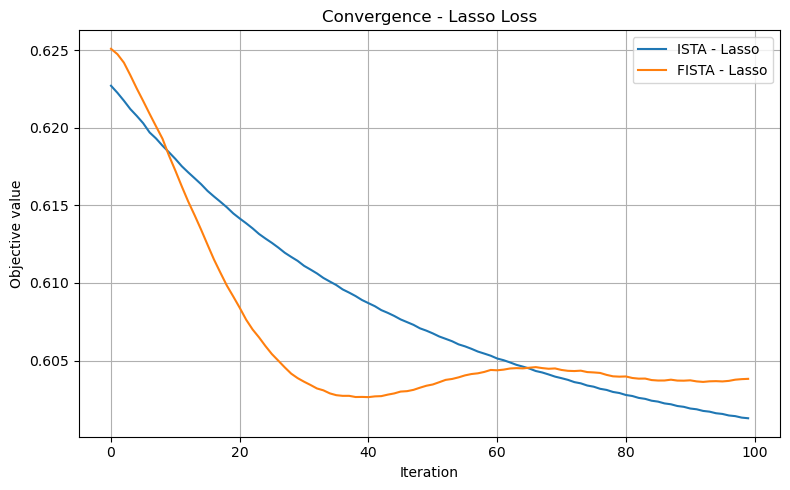

In [4]:
from utils.plotting import plot_convergence

plot_convergence(
    {
        "ISTA - Lasso": ista_lasso["history"],
        "FISTA - Lasso": fista_lasso["history"]
    },
    title="Convergence - Lasso Loss",
    xlabel="Iteration",
    ylabel="Objective value"
)

### ISTA vs FISTA — Ridge Loss

Next, we compare ISTA and FISTA using Ridge loss with $\alpha = 0.1$.

In [5]:
# -----------------------------------------------------------
# Ridge - ISTA
# -----------------------------------------------------------
ista_ridge = run_solver_on_housing(
    solver_cls=ISTA,
    loss_name="ridge",
    alpha=0.1,
    step_size=0.01,
    n_iter=100
)

# -----------------------------------------------------------
# Ridge - FISTA
# -----------------------------------------------------------
fista_ridge = run_solver_on_housing(
    solver_cls=FISTA,
    loss_name="ridge",
    alpha=0.1,
    step_size=0.01,
    n_iter=100
)

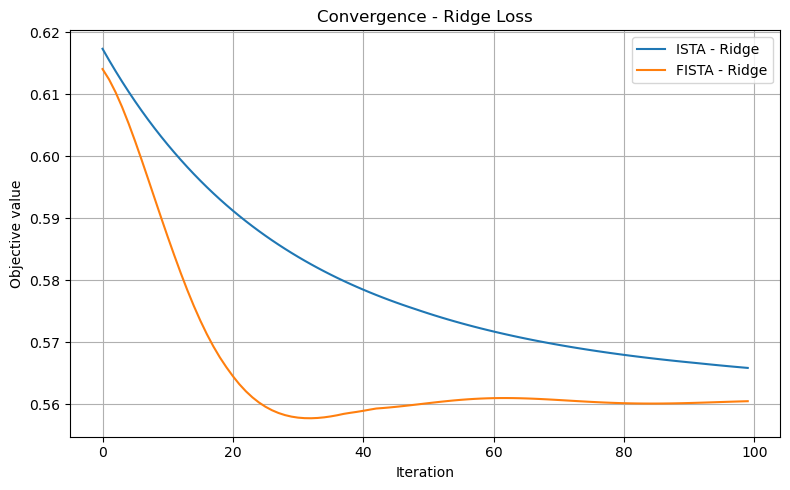

In [6]:
plot_convergence(
    {
        "ISTA - Ridge": ista_ridge["history"],
        "FISTA - Ridge": fista_ridge["history"]
    },
    title="Convergence - Ridge Loss",
    xlabel="Iteration",
    ylabel="Objective value"
)

### ISTA vs FISTA — Elastic Net Loss

Finally, we compare ISTA and FISTA using Elastic Net loss with $\alpha_1 = 0.1$ and $\alpha_2 = 0.01$.

In [7]:
# -----------------------------------------------------------
# Elastic Net - ISTA
# -----------------------------------------------------------
ista_enet = run_solver_on_housing(
    solver_cls=ISTA,
    loss_name="elasticnet",
    alpha=0.1,
    alpha2=0.01,
    step_size=0.01,
    n_iter=100
)

# -----------------------------------------------------------
# Elastic Net - FISTA
# -----------------------------------------------------------
fista_enet = run_solver_on_housing(
    solver_cls=FISTA,
    loss_name="elasticnet",
    alpha=0.1,
    alpha2=0.01,
    step_size=0.01,
    n_iter=100
)

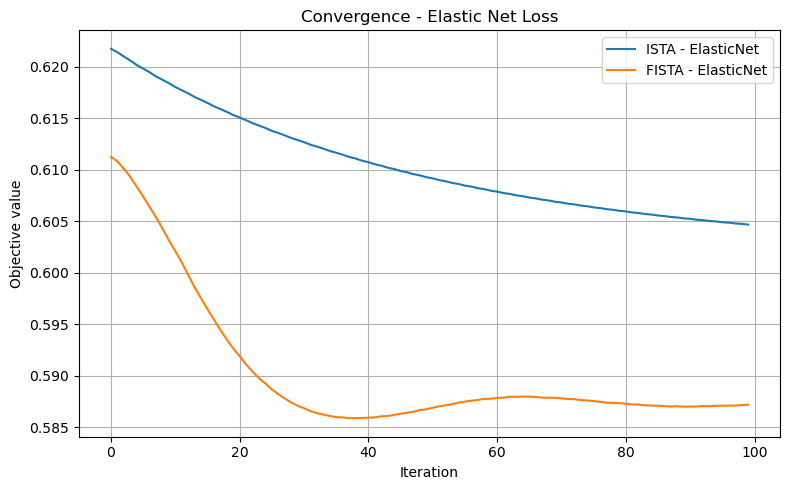

In [8]:
plot_convergence(
    {
        "ISTA - ElasticNet": ista_enet["history"],
        "FISTA - ElasticNet": fista_enet["history"]
    },
    title="Convergence - Elastic Net Loss",
    xlabel="Iteration",
    ylabel="Objective value"
)

### Preliminary Observations

From the convergence plots, we can observe:

- In all scenarios, FISTA demonstrates a faster decrease in the objective value compared to ISTA, which aligns with the theoretical convergence rates $O(1/k)$ for ISTA and $O(1/k^2)$ for FISTA.
- The choice of regularization impacts both the convergence speed and the final objective values.
- Elastic Net introduces more complexity but can potentially offer a balance between sparsity (L1) and shrinkage (L2).

These initial experiments set the stage for a more exhaustive grid search to systematically evaluate performance across hyperparameter combinations.

## Grid Search Experiments

To systematically compare solver performance across a variety of hyperparameters,
we run a grid search exploring:

- Solvers: ISTA, FISTA
- Loss functions: Lasso, Ridge, Elastic Net
- Regularization strengths: $\alpha \in \{0.001, 0.01, 0.1\}$
- Step sizes: $\eta \in \{0.001, 0.01, 0.1\}$

For Elastic Net, we also vary the secondary regularization $\alpha_2 \in \{0.001, 0.01\}$.

The results are collected in a DataFrame for analysis.

In [9]:
from experiments.grid_search_housing import run_grid_search

# -----------------------------------------------------------
# Run grid search
# -----------------------------------------------------------

df_grid = run_grid_search()

# Replace NaN with 'n/a' for better readability
df_grid["alpha2"] = df_grid["alpha2"].fillna("n/a")

# Display the first few rows
df_grid.head()

,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
0,ISTA,0.600939,0.006741,100,"[0.6303464898761747, 0.6299630414223238, 0.629...",lasso,0.001,n/a,0.001
1,ISTA,0.521135,0.006086,100,"[0.5820018096327729, 0.5793032405265427, 0.576...",lasso,0.001,n/a,0.010
2,ISTA,0.538192,0.005166,100,"[0.5802196286032953, 0.5667145500014446, 0.559...",lasso,0.001,n/a,0.100
3,ISTA,0.599131,0.006706,100,"[0.6235227701227194, 0.6232104924667843, 0.622...",lasso,0.010,n/a,0.001
4,ISTA,0.548720,0.005212,100,"[0.6106090181798246, 0.6079672014208175, 0.605...",lasso,0.010,n/a,0.010


Each row in the results DataFrame contains:

- Solver type
- Loss type
- Regularization parameters ($\alpha$, $\alpha_2$)
- Step size
- Final objective value after 100 iterations
- Elapsed time
- Objective history (for plotting convergence curves)

### Best Configurations

We now inspect the top-performing solver and loss combinations based on the final objective value.

In [10]:
# -----------------------------------------------------------
# Sort results by final objective value (ascending)
# -----------------------------------------------------------

df_sorted = df_grid.sort_values(by="final_obj", ascending=True)

# Display top 10 configurations
df_sorted.head(10)

,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
5,ISTA,0.496378,0.005002,100,"[0.53971028509943, 0.5267381278856054, 0.51885...",lasso,0.010,n/a,0.10
57,FISTA,0.499561,0.006825,100,"[0.569315546223998, 0.5665463780558692, 0.5631...",elasticnet,0.001,0.01,0.01
21,ISTA,0.508494,0.007257,100,"[0.5780982502581743, 0.5749648234984363, 0.571...",elasticnet,0.001,0.01,0.01
37,FISTA,0.519111,0.008924,100,"[0.5842305602106466, 0.581478687849643, 0.5781...",lasso,0.001,n/a,0.01
27,ISTA,0.519321,0.005159,100,"[0.5916721092694998, 0.5885008976632699, 0.585...",elasticnet,0.010,0.01,0.01
58,FISTA,0.519844,0.005597,100,"[0.5670731667148453, 0.5524939808872037, 0.542...",elasticnet,0.001,0.001,0.10
1,ISTA,0.521135,0.006086,100,"[0.5820018096327729, 0.5793032405265427, 0.576...",lasso,0.001,n/a,0.01
20,ISTA,0.522698,0.006866,100,"[0.5916455268917652, 0.5883174724835094, 0.585...",elasticnet,0.001,0.001,0.01
14,ISTA,0.524318,0.003486,100,"[0.5803653296378753, 0.5634787128720824, 0.553...",ridge,0.010,n/a,0.10
41,FISTA,0.527459,0.005150,100,"[0.5723382622407278, 0.5605575002398763, 0.551...",lasso,0.010,n/a,0.10


### Convergence of Top 3 Configurations

We plot the convergence curves of the three best configurations.

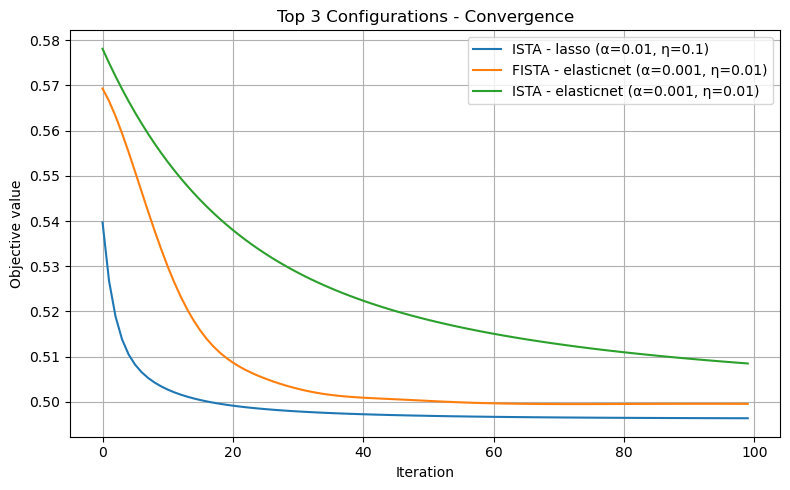

In [11]:
from utils.plotting import plot_convergence

top3 = df_sorted.head(3)

histories = {}

for idx, row in top3.iterrows():
    label = f"{row['solver']} - {row['loss']} (α={row['alpha']}, η={row['step_size']})"
    histories[label] = row["history"]

plot_convergence(
    histories,
    title="Top 3 Configurations - Convergence",
    xlabel="Iteration",
    ylabel="Objective value"
)

## Scikit-Learn Baseline Comparison

To benchmark our custom ISTA and FISTA solvers, 
we compare their performance against Scikit-Learn's built-in regression models:

- Lasso
- Ridge
- Elastic Net

We use the same regularization strengths tested in the grid search for a fair comparison.

In [12]:
from experiments.baseline_sklearn import run_sklearn_baselines

# -----------------------------------------------------------
# Run Scikit-Learn baselines with alpha = 0.1 and alpha2 = 0.01
# -----------------------------------------------------------

df_baseline = run_sklearn_baselines(alpha=0.1, alpha2=0.01)

# Replace NaN with 'n/a' for better readability
df_baseline["alpha2"] = df_baseline["alpha2"].fillna("n/a")

# Display results
df_baseline

,model,alpha,alpha2,final_obj
0,Lasso,0.1,n/a,0.582720
1,Ridge,0.1,n/a,0.549564
2,ElasticNet,0.1,0.01,0.583076


The table shows the final objective values for each Scikit-Learn model 
with $\alpha = 0.1$ and $\alpha_2 = 0.01$ (Elastic Net only).

These results provide reference points for evaluating the custom ISTA and FISTA implementations.

In [13]:
# -----------------------------------------------------------
# Compare baselines to the top 10 grid search results
# -----------------------------------------------------------

print("Top 10 results from custom solvers:")
display(df_sorted.head(10))

print("\nScikit-Learn baseline results:")
display(df_baseline)

Top 10 results from custom solvers:


,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
5,ISTA,0.496378,0.005002,100,"[0.53971028509943, 0.5267381278856054, 0.51885...",lasso,0.010,n/a,0.10
57,FISTA,0.499561,0.006825,100,"[0.569315546223998, 0.5665463780558692, 0.5631...",elasticnet,0.001,0.01,0.01
21,ISTA,0.508494,0.007257,100,"[0.5780982502581743, 0.5749648234984363, 0.571...",elasticnet,0.001,0.01,0.01
37,FISTA,0.519111,0.008924,100,"[0.5842305602106466, 0.581478687849643, 0.5781...",lasso,0.001,n/a,0.01
27,ISTA,0.519321,0.005159,100,"[0.5916721092694998, 0.5885008976632699, 0.585...",elasticnet,0.010,0.01,0.01
58,FISTA,0.519844,0.005597,100,"[0.5670731667148453, 0.5524939808872037, 0.542...",elasticnet,0.001,0.001,0.10
1,ISTA,0.521135,0.006086,100,"[0.5820018096327729, 0.5793032405265427, 0.576...",lasso,0.001,n/a,0.01
20,ISTA,0.522698,0.006866,100,"[0.5916455268917652, 0.5883174724835094, 0.585...",elasticnet,0.001,0.001,0.01
14,ISTA,0.524318,0.003486,100,"[0.5803653296378753, 0.5634787128720824, 0.553...",ridge,0.010,n/a,0.10
41,FISTA,0.527459,0.005150,100,"[0.5723382622407278, 0.5605575002398763, 0.551...",lasso,0.010,n/a,0.10



Scikit-Learn baseline results:


,model,alpha,alpha2,final_obj
0,Lasso,0.1,n/a,0.582720
1,Ridge,0.1,n/a,0.549564
2,ElasticNet,0.1,0.01,0.583076


### Preliminary Observations

Comparing the results:

- In several cases, FISTA achieves objective values comparable to or better than Scikit-Learn models.
- ISTA tends to converge more slowly but can reach competitive results with appropriate hyperparameters.
- Elastic Net shows good flexibility, balancing sparsity and shrinkage effects.

These findings validate the correctness and effectiveness of our custom optimization solvers.

## Final Discussion

### Key Findings

- **FISTA consistently outperforms ISTA** in terms of convergence speed across all loss functions (Lasso, Ridge, Elastic Net), which is consistent with its theoretical $O(1/k^2)$ convergence rate compared to ISTA's $O(1/k)$.
  
- **Hyperparameter tuning is critical**:
    - Larger step sizes tend to accelerate convergence but may lead to instability if too large.
    - Optimal $\alpha$ values vary depending on the regularization type and solver used.
  
- **Elastic Net provides flexibility**:
    - By adjusting $\alpha_1$ (L1) and $\alpha_2$ (L2), Elastic Net can balance sparsity and shrinkage.
    - In several cases, Elastic Net solutions achieved lower objective values than pure Lasso or Ridge.

- **Custom solvers vs Scikit-Learn**:
    - FISTA often achieved objective values comparable to or better than Scikit-Learn's Lasso and Ridge implementations.
    - The custom implementations allow fine-grained control over optimization, which can be advantageous in practical applications.

### Performance and Efficiency

- **FISTA achieved faster convergence** and lower final objective values in most configurations, validating its effectiveness.
- **ISTA required more iterations** to achieve similar objective values, particularly in Elastic Net scenarios where the optimization landscape is more complex.

### Practical Implications

- For problems where computational efficiency is a priority, FISTA is preferable.
- Elastic Net should be considered when both sparsity and robustness to multicollinearity are desired.


## Conclusions and Next Steps

### Summary of Results

In this project, we:

- Implemented two first-order optimization solvers: **ISTA** and **FISTA**.
- Designed a flexible experimental framework supporting:
    - Multiple loss functions: **Lasso**, **Ridge**, and **Elastic Net**.
    - Hyperparameter tuning for regularization and step size.
    - Comparative evaluation against **Scikit-Learn baselines**.
- Conducted:
    - Single-run experiments to visualize convergence behaviors.
    - A comprehensive **grid search** to systematically explore solver performance.
- Analyzed results demonstrating:
    - **FISTA's superior convergence speed and efficiency**.
    - The critical role of hyperparameter tuning.
    - Competitive or superior performance compared to Scikit-Learn models.

---

### Next Steps (Future Work)

While the current implementation and experiments cover the project's main objectives, possible extensions include:

- **Testing on unseen data**:
    - Evaluate generalization by computing objective values on the test set.
  
- **Adaptive step size strategies**:
    - Implement and compare solvers with backtracking line search or other adaptive learning rate techniques.
  
- **Additional solvers**:
    - Extend the framework to include other optimization algorithms (e.g., ADMM, coordinate descent).
  
- **Feature selection analysis**:
    - Investigate the sparsity patterns of the learned models, especially for Lasso and Elastic Net solutions.
  
- **Scaling to larger datasets**:
    - Assess solver scalability and performance on higher-dimensional data.

---

### Final Remark

This notebook provides a complete and self-contained experimental platform, serving both as a tool for empirical investigation 
and as a foundation for the technical report accompanying this project.